In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #data visualization
import seaborn as sns
from sklearn.model_selection import train_test_split # Split data to train and test data(after merging in this case)
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix 
import warnings
warnings.filterwarnings('ignore')


# import libraries from tensorflow
from tensorflow import keras
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,Input, BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import HeUniform

In [2]:
pd.set_option('display.max_rows', None) 
df = pd.read_excel("AmidationDataset_29July_CuratedDataset1.xlsx")
df.head()

,Acid (name),Acid (equiv.),Amine (name),Amine (equiv.),Activator (name),Activator (equiv.),Base (name),Base (equiv.),Solvent,Global Conc (M),Temp (C),Time (h),Reaction_Yield,References
0,N-Boc-L-leucine,1.0,Piperidine,1.1,EDCI,1.1,Piperidine,1.0,DCM,0.60,25,2.0,96,https://doi.org/10.1039/C2CC31735D
1,N-Boc-L-leucine,1.0,Piperidine,1.1,DCC,1.5,Piperidine,1.0,DCM,0.25,25,1.5,88,https://doi.org/10.1021/acsomega.0c06053
2,N-Boc-L-leucine,1.0,Piperidine,1.1,HBTU,1.5,DIPEA,2.0,DMF,0.50,25,1.0,96,10.1021/jo0349375
3,N-Boc-L-tert-leucine,1.0,Piperidine,1.1,HBTU,1.5,DIPEA,2.0,DMF,0.50,25,16.0,90,https://doi.org/10.1002/ejoc.202100355
4,N-Boc-L-tert-leucine,1.0,Piperidine,1.1,HBTU,1.5,DIPEA,2.0,DMF,0.50,25,16.0,86,https://doi.org/10.1002/chem.201002202


In [3]:
#dropped Additive for trial
df = df.drop(['References'], axis=1)
df.head(1)

,Acid (name),Acid (equiv.),Amine (name),Amine (equiv.),Activator (name),Activator (equiv.),Base (name),Base (equiv.),Solvent,Global Conc (M),Temp (C),Time (h),Reaction_Yield
0,N-Boc-L-leucine,1.0,Piperidine,1.1,EDCI,1.1,Piperidine,1.0,DCM,0.6,25,2.0,96


In [4]:
df.isnull().sum()

Acid (name)           0
Acid (equiv.)         0
Amine (name)          0
Amine (equiv.)        0
Activator (name)      0
Activator (equiv.)    1
Base (name)           0
Base (equiv.)         0
Solvent               0
Global Conc (M)       0
Temp (C)              0
Time (h)              1
Reaction_Yield        0
dtype: int64

In [5]:
#Data Imputation
from sklearn.impute import SimpleImputer

# Columns with missing values
missing_columns = ['Activator (equiv.)', 'Time (h)']

# 1. Imputation for numerical features (using mean or median)
numerical_columns = ['Acid (equiv.)', 'Amine (equiv.)', 'Activator (equiv.)', 'Base (equiv.)', 
                     'Global Conc (M)', 'Temp (C)', 'Time (h)']

# Create a SimpleImputer for numerical columns (using 'mean' strategy)
imputer_num = SimpleImputer(strategy='mean')

# Apply the imputer to numerical columns
df[numerical_columns] = imputer_num.fit_transform(df[numerical_columns])

In [6]:
df.isnull().sum()

Acid (name)           0
Acid (equiv.)         0
Amine (name)          0
Amine (equiv.)        0
Activator (name)      0
Activator (equiv.)    0
Base (name)           0
Base (equiv.)         0
Solvent               0
Global Conc (M)       0
Temp (C)              0
Time (h)              0
Reaction_Yield        0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Acid (name)         172 non-null    object 
 1   Acid (equiv.)       172 non-null    float64
 2   Amine (name)        172 non-null    object 
 3   Amine (equiv.)      172 non-null    float64
 4   Activator (name)    172 non-null    object 
 5   Activator (equiv.)  172 non-null    float64
 6   Base (name)         172 non-null    object 
 7   Base (equiv.)       172 non-null    float64
 8   Solvent             172 non-null    object 
 9   Global Conc (M)     172 non-null    float64
 10  Temp (C)            172 non-null    float64
 11  Time (h)            172 non-null    float64
 12  Reaction_Yield      172 non-null    int64  
dtypes: float64(7), int64(1), object(5)
memory usage: 17.6+ KB


# Divide Train/Test split

In [66]:
# Splitting the dataset into features (X) and target variable (y)
X_train = df.drop(columns=['Reaction_Yield'])
y_train = df['Reaction_Yield']

# Splitting into training and testing datasets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Display the first few rows of the preprocessed data
X_train.shape

(172, 12)

In [67]:
df_test = pd.read_excel("CHEM-testDATASET.xlsx")
df_test.drop('References',axis=1,inplace=True)
# Splitting the test dataset into features (X) and target variable (y)
X_test = df_test.drop(columns=['Reaction_Yield'])
y_test = df_test['Reaction_Yield']

In [10]:
X_test.shape

(20, 12)

## Categorical Encoding

In [68]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# List of categorical columns
categorical_columns = ['Acid (name)', 'Amine (name)', 'Activator (name)', 'Base (name)', 'Solvent']

# Initialize a dictionary to store the label encoders for each column
label_encoders = {}

# Apply label encoding to each categorical column in both train and test data
for col in categorical_columns:
    label_encoder = LabelEncoder()
    
    # Fit the label encoder on the training data
    X_train[col] = label_encoder.fit_transform(X_train[col])
    
    # Store the label encoder for later use
    label_encoders[col] = label_encoder
    
    # For the test data, handle unseen labels by converting them to a new category
    unseen_mask = ~X_test[col].isin(label_encoder.classes_)
    X_test.loc[unseen_mask, col] = 'Unknown'  # or assign another placeholder category
    
    # Add 'Unknown' to the label encoder classes
    label_encoder.classes_ = np.append(label_encoder.classes_, 'Unknown')
    
    # Transform the test data
    X_test[col] = label_encoder.transform(X_test[col])



## Acronyms used in this notebook:
 - Representation Learning - RL
 - Gradient Boosting - GB
 - Extreme Gradient Boosting - XGBoost
 - Random Forest - RF
 - Support Vector Regressor - SVR



## Best performing model. Used RL + GB with Bayesian optimization for efficient hyperparameter tuning.

### Optuna Optimized ModelRMSE: 5.513202411327387 R-squared (R²): 0.8000927287310471

In [12]:
import optuna
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import numpy as np
import random
import tensorflow as tf

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# 1. Autoencoder Model (Representation Learning)
input_dim = X_train.shape[1]
encoding_dim = 10  # Increased the dimension of the latent representation

# Define a deeper Autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)  # Increased the number of neurons
encoded = Dropout(0.3)(encoded)  # Increased dropout rate
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder model (for extracting learned representations)
encoder = Model(inputs=input_layer, outputs=encoded)

# Compile the autoencoder with a smaller learning rate
autoencoder.compile(optimizer=Adam(learning_rate=0.0004), loss='mse')

# 2. Train the autoencoder with cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    
    # Train the autoencoder on the current fold with more epochs #batch_size=32
    autoencoder.fit(X_train_fold, X_train_fold, epochs=300, batch_size=32, shuffle=False, validation_data=(X_val_fold, X_val_fold), verbose=0)

# 3. Extract learned representations from the encoder
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        #'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None]),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
        #'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0)
    }
    model = GradientBoostingRegressor(**params, random_state=42)
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)
    mse = mean_squared_error(y_test, y_pred)
    return mse

#study = optuna.create_study(direction='minimize')
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))  # Add seed to the sampler
study.optimize(objective, n_trials=200)

best_params = study.best_params
best_model = GradientBoostingRegressor(**best_params, random_state=42)
best_model.fit(X_train_encoded, y_train)
y_pred = best_model.predict(X_test_encoded)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Optuna Optimized Model RMSE: {rmse}")
print(f"R-squared (R²): {r2}")


1/1 [==============================] - 0s 9ms/step


[I 2024-09-20 17:40:15,817] A new study created in memory with name: no-name-2e4eb876-39b2-4ca1-b577-ba68783b2c62
[I 2024-09-20 17:40:16,232] Trial 0 finished with value: 53.66602471700173 and parameters: {'n_estimators': 874, 'learning_rate': 0.039847274093219656, 'max_depth': 8, 'subsample': 0.8394633936788146, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'alpha': 1.4610865886287176e-08}. Best is trial 0 with value: 53.66602471700173.
[I 2024-09-20 17:40:16,967] Trial 1 finished with value: 73.03517006623561 and parameters: {'n_estimators': 1470, 'learning_rate': 0.023112945005104156, 'max_depth': 4, 'subsample': 0.6727299868828402, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'alpha': 1.3060231803531604e-07}. Best is trial 0 with value: 53.66602471700173.
[I 2024-09-20 17:40:17,308] Trial 2 finished with value: 74.33867671154096 and parameters: {'n_estimators': 792, 'learning_rate': 0.0027020519273236636, 'max_depth': 6, 'subsample':

[I 2024-09-20 17:40:31,387] Trial 23 finished with value: 59.044757891925634 and parameters: {'n_estimators': 969, 'learning_rate': 0.029129676905499228, 'max_depth': 10, 'subsample': 0.990070990601376, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'alpha': 4.812875290445273e-05}. Best is trial 22 with value: 51.44309652718374.
[I 2024-09-20 17:40:32,268] Trial 24 finished with value: 54.9743605078423 and parameters: {'n_estimators': 854, 'learning_rate': 0.014891468718872921, 'max_depth': 9, 'subsample': 0.9617969629551628, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'alpha': 0.015212368756540242}. Best is trial 22 with value: 51.44309652718374.
[I 2024-09-20 17:40:33,346] Trial 25 finished with value: 66.01042314006264 and parameters: {'n_estimators': 1031, 'learning_rate': 0.017821254721076252, 'max_depth': 10, 'subsample': 0.8900646198797657, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'alpha': 0.0001663246206

[I 2024-09-20 17:40:43,733] Trial 47 finished with value: 40.996643487222556 and parameters: {'n_estimators': 666, 'learning_rate': 0.021041222228553008, 'max_depth': 4, 'subsample': 0.9372635089116057, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None, 'alpha': 7.628029184729486e-07}. Best is trial 47 with value: 40.996643487222556.
[I 2024-09-20 17:40:44,168] Trial 48 finished with value: 51.80843122294529 and parameters: {'n_estimators': 649, 'learning_rate': 0.019978211237209872, 'max_depth': 5, 'subsample': 0.8707439490394671, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None, 'alpha': 4.005960392519893e-06}. Best is trial 47 with value: 40.996643487222556.
[I 2024-09-20 17:40:44,627] Trial 49 finished with value: 57.09007685625171 and parameters: {'n_estimators': 604, 'learning_rate': 0.014841275018413256, 'max_depth': 7, 'subsample': 0.8250467632606295, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': None, 'alpha': 1.06843566877

[I 2024-09-20 17:41:01,017] Trial 71 finished with value: 38.13353190292665 and parameters: {'n_estimators': 1346, 'learning_rate': 0.022400923781651788, 'max_depth': 4, 'subsample': 0.9388741470751607, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 3.0802589529365674e-08}. Best is trial 66 with value: 33.44549363507407.
[I 2024-09-20 17:41:01,854] Trial 72 finished with value: 40.44466310879479 and parameters: {'n_estimators': 1345, 'learning_rate': 0.0322816383538631, 'max_depth': 4, 'subsample': 0.9514503941178026, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 3.233018962064979e-08}. Best is trial 66 with value: 33.44549363507407.
[I 2024-09-20 17:41:02,683] Trial 73 finished with value: 38.90388423264328 and parameters: {'n_estimators': 1303, 'learning_rate': 0.018319669713888438, 'max_depth': 4, 'subsample': 0.9527958236678176, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 2.301258

[I 2024-09-20 17:41:20,427] Trial 95 finished with value: 44.141897859149495 and parameters: {'n_estimators': 1395, 'learning_rate': 0.030373718296522616, 'max_depth': 3, 'subsample': 0.9245267695085209, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 1.1106784709203208e-07}. Best is trial 66 with value: 33.44549363507407.
[I 2024-09-20 17:41:21,387] Trial 96 finished with value: 36.79839593256703 and parameters: {'n_estimators': 1367, 'learning_rate': 0.03381499931893928, 'max_depth': 5, 'subsample': 0.9582779005132603, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 0.002413528872620194}. Best is trial 66 with value: 33.44549363507407.
[I 2024-09-20 17:41:22,373] Trial 97 finished with value: 53.525937364005415 and parameters: {'n_estimators': 1366, 'learning_rate': 0.033625943478433375, 'max_depth': 5, 'subsample': 0.9527377193618147, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'auto', 'alpha': 0.0021

[I 2024-09-20 17:41:41,852] Trial 119 finished with value: 37.56922934436945 and parameters: {'n_estimators': 1080, 'learning_rate': 0.04392303420887773, 'max_depth': 5, 'subsample': 0.8384965947529667, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 6.005029678127046e-08}. Best is trial 66 with value: 33.44549363507407.
[I 2024-09-20 17:41:42,712] Trial 120 finished with value: 45.7979768917189 and parameters: {'n_estimators': 1243, 'learning_rate': 0.03640511658085995, 'max_depth': 5, 'subsample': 0.9306037871610617, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 0.0003303589642946579}. Best is trial 66 with value: 33.44549363507407.
[I 2024-09-20 17:41:43,316] Trial 121 finished with value: 40.53689896611037 and parameters: {'n_estimators': 934, 'learning_rate': 0.04363465034039702, 'max_depth': 5, 'subsample': 0.8293844753926475, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 0.0012825

[I 2024-09-20 17:42:01,378] Trial 143 finished with value: 37.45817630107943 and parameters: {'n_estimators': 1434, 'learning_rate': 0.03778261208233063, 'max_depth': 4, 'subsample': 0.9046120469734196, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 3.2796159019936415e-08}. Best is trial 66 with value: 33.44549363507407.
[I 2024-09-20 17:42:02,293] Trial 144 finished with value: 36.74552510439828 and parameters: {'n_estimators': 1437, 'learning_rate': 0.028248036410570162, 'max_depth': 4, 'subsample': 0.9031457980582268, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 1.5185883046037607e-08}. Best is trial 66 with value: 33.44549363507407.
[I 2024-09-20 17:42:03,076] Trial 145 finished with value: 52.33014804404071 and parameters: {'n_estimators': 1468, 'learning_rate': 0.020528267773094525, 'max_depth': 3, 'subsample': 0.925695948286603, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 1.70

[I 2024-09-20 17:42:22,078] Trial 167 finished with value: 39.38038212648452 and parameters: {'n_estimators': 1395, 'learning_rate': 0.03656057507538979, 'max_depth': 5, 'subsample': 0.9148804502837915, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 0.00013149146362595403}. Best is trial 66 with value: 33.44549363507407.
[I 2024-09-20 17:42:22,922] Trial 168 finished with value: 35.7104464411195 and parameters: {'n_estimators': 1355, 'learning_rate': 0.045673141241053455, 'max_depth': 4, 'subsample': 0.9300309158238301, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 4.112445208195128e-08}. Best is trial 66 with value: 33.44549363507407.
[I 2024-09-20 17:42:23,407] Trial 169 finished with value: 53.408889212631934 and parameters: {'n_estimators': 1299, 'learning_rate': 0.049882202878928986, 'max_depth': 4, 'subsample': 0.9297424451904912, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'alpha': 3.23

[I 2024-09-20 17:42:40,702] Trial 190 finished with value: 37.09636512094356 and parameters: {'n_estimators': 1312, 'learning_rate': 0.036432469719094945, 'max_depth': 4, 'subsample': 0.9348016418114764, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 2.415301675571572e-08}. Best is trial 180 with value: 30.395400828266112.
[I 2024-09-20 17:42:41,489] Trial 191 finished with value: 35.984783572651395 and parameters: {'n_estimators': 1251, 'learning_rate': 0.04205410534187231, 'max_depth': 4, 'subsample': 0.9492494320485124, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 1.543371834584237e-08}. Best is trial 180 with value: 30.395400828266112.
[I 2024-09-20 17:42:42,260] Trial 192 finished with value: 33.03645859356585 and parameters: {'n_estimators': 1236, 'learning_rate': 0.038698539350651755, 'max_depth': 4, 'subsample': 0.9387550385056602, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'alpha': 

Optuna Optimized Model RMSE: 5.513202411327387
R-squared (R²): 0.8000927287310471


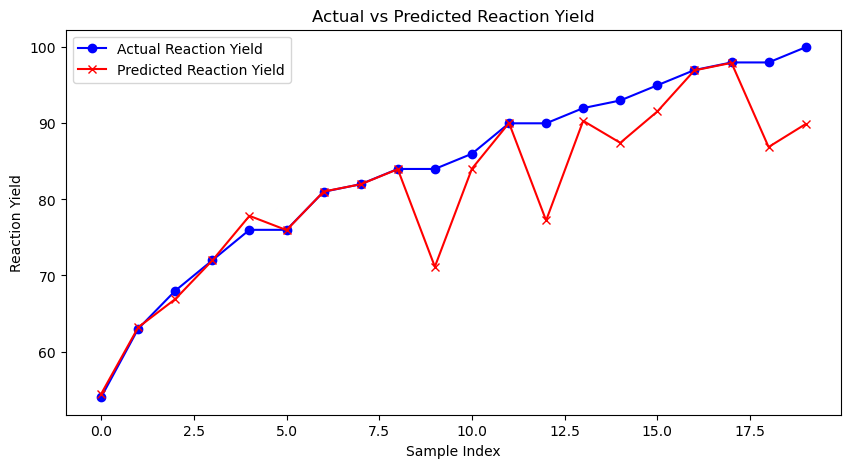

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume y_test contains the actual values and y_pred contains the predicted values

# Pair the y_test and y_pred values together and sort by y_test
sorted_pairs = sorted(zip(y_test, y_pred), key=lambda pair: pair[0])
y_test_sorted, y_pred_sorted = zip(*sorted_pairs)

# Convert sorted pairs to numpy arrays for plotting (if needed)
y_test_sorted = np.array(y_test_sorted)
y_pred_sorted = np.array(y_pred_sorted)

# Set up the plotting area
plt.figure(figsize=(10, 5))

# Line Plot of Actual vs Predicted
#plt.plot(y_test.values, label='Actual Reaction Yield', color='blue', marker='o')
#plt.plot(y_pred, label='Predicted Reaction Yield', color='red', marker='x')

plt.plot(y_test_sorted, label='Actual Reaction Yield', color='blue', marker='o')
plt.plot(y_pred_sorted, label='Predicted Reaction Yield', color='red', marker='x')

# Add title and labels
plt.title('Actual vs Predicted Reaction Yield')
plt.xlabel('Sample Index')
plt.ylabel('Reaction Yield')

# Add a legend
plt.legend()

# Save the plot to a file
#plt.savefig('actualvspredicted_yield_RLGB_TrainD112_Test20_80R2.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [14]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
results_df

,Actual,Predicted
0,98,97.944868
1,90,90.043754
2,72,71.981538
3,76,77.836285
4,100,89.904756
5,68,66.903042
6,84,83.967908
7,92,90.326130
8,82,81.986705
9,63,63.183840


In [15]:
#Recompute MSE on normalised/scaled ground truth and prediction

from sklearn.preprocessing import MinMaxScaler
# Create the scaler and fit it on the actual Zoom values
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

# Predict with your model
#y_pred = best_model.predict(X_test)

# Normalize predictions - Ensure predictions are reshaped for scaler compatibility if needed
y_pred_scaled = scaler.transform(y_pred.reshape(-1, 1))


In [16]:
# Compute MSE on the normalized scale
mse_normalized = mean_squared_error(y_test_scaled, y_pred_scaled)
print("Mean Squared Error on Normalized Scale for Focus: ", mse_normalized)

Mean Squared Error on Normalized Scale for Focus:  0.01436455615702557


In [17]:
import math
rmse = math.sqrt(mse_normalized)
print(f"Root Mean Squared Error for Reaction Yield: {rmse}")

Root Mean Squared Error for Reaction Yield: 0.11985222633320405


In [18]:
r2 = r2_score(y_test_scaled, y_pred_scaled)
print(f"R-squared (R²): {r2}")

R-squared (R²): 0.8000927287310472


### Representation Learning + Gradient Boosting + Hyperparameter tuning using Optuna is the BEST MODEL

### RMSE: 0.11985222633320405, R-squared (R²): 0.8000927287310472

## Try all poor performing models - XGBoost, RandomForest, SVR, Gradient Boosting(Single)

## XGBoost single

In [21]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the features and target
#X = df.drop(columns=['Reaction_Yield'])  # Features
#y = df['Reaction_Yield']  # Target

# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

'''
# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'max_depth': 6,  # Maximum depth of a tree
    'eta': 0.1,  # Learning rate
    'nthread': 4,  # Number of threads for parallel processing
    'eval_metric': 'rmse'  # Evaluation metric
}

# Train the model using XGBoost
num_boost_round = 200
bst = xgb.train(params, dtrain, num_boost_round)
'''
# Set XGBoost parameters (updated with more tuned parameters)
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'max_depth': 8,  # Increased depth for more complexity
    'eta': 0.01,  # Reduced learning rate for better convergence
    'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'nthread': 4,  # Number of threads for parallel processing
    'eval_metric': 'rmse'  # Evaluation metric
}

# Use cross-validation to find the optimal number of boosting rounds with early stopping
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=50,
    metrics="rmse",
    as_pandas=True,
    seed=42
)

# Train the model using the optimal number of boosting rounds from cross-validation
num_boost_round = cv_results['test-rmse-mean'].argmin() + 1
bst = xgb.train(params, dtrain, num_boost_round=num_boost_round)

# Predict on the test set
y_pred = bst.predict(dtest)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Root Mean Squared Error (RMSE): 10.21
R-squared (R²): 0.31


In [22]:
#Recompute MSE on normalised/scaled ground truth and prediction

from sklearn.preprocessing import MinMaxScaler
# Create the scaler and fit it on the actual Zoom values
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

# Predict with your model
#y_pred = best_model.predict(X_test)

# Normalize predictions - Ensure predictions are reshaped for scaler compatibility if needed
y_pred_scaled = scaler.transform(y_pred.reshape(-1, 1))

# Compute MSE on the normalized scale
mse_normalized = mean_squared_error(y_test_scaled, y_pred_scaled)
print("Mean Squared Error on Normalized Scale for Reaction Yield: ", mse_normalized)

import math
rmse = math.sqrt(mse_normalized)
print(f"Root Mean Squared Error for Reaction Yield: {rmse}")
r2 = r2_score(y_test_scaled, y_pred_scaled)
print(f"R-squared (R²): {r2}")


Mean Squared Error on Normalized Scale for Reaction Yield:  0.04924935936922285
Root Mean Squared Error for Reaction Yield: 0.2219219668469592
R-squared (R²): 0.3146112601307123


## Trying RL using XGBoost

In [23]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np

import random

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Assuming X_train and X_test are your preprocessed datasets
# Make sure to load/prepare X_train, X_test, y_train, y_test appropriately

# Autoencoder Model for Representation Learning
input_dim = X_train.shape[1]  # Input dimension
encoding_dim = 10  # Latent representation dimension

# Define Autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Build Autoencoder and Encoder models
autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

# Compile Autoencoder with Adam optimizer
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Use K-Fold Cross Validation to train the Autoencoder
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    
    # Train Autoencoder on each fold
    autoencoder.fit(X_train_fold, X_train_fold, epochs=60, batch_size=16, shuffle=False, validation_data=(X_val_fold, X_val_fold))

# Extract learned representations (encoded data) from the Encoder
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Use XGBoost for regression on the encoded data

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dtest = xgb.DMatrix(X_test_encoded, label=y_test)

# XGBoost parameters (fine-tuned)
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 8,  # Increased depth for better feature learning
    'eta': 0.006,  # Lower learning rate for gradual learning
    'min_child_weight': 3,  # Prevents overfitting
    #'subsample': 0.8,  # Randomly sample 80% of data for each tree
    #'colsample_bytree': 0.8,  # Randomly sample 80% of features for each tree
    'nthread': 4,  # Parallel threads for faster processing
    'eval_metric': 'rmse'  # Use RMSE as evaluation metric
}

# Train the XGBoost model using early stopping to prevent overfitting
num_boost_round = 200  # Max number of boosting iterations
early_stopping_rounds = 50  # Stop if no improvement in 50 rounds
bst = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(dtest, 'eval')], early_stopping_rounds=early_stopping_rounds)

# Predict on the test set
y_pred = bst.predict(dtest)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Epoch 1/60
9/9 [==============================] - 0s 9ms/step - loss: 626.3514 - val_loss: 310.8026
Epoch 2/60
9/9 [==============================] - 0s 2ms/step - loss: 620.4590 - val_loss: 310.6670
Epoch 3/60
9/9 [==============================] - 0s 2ms/step - loss: 620.3398 - val_loss: 310.6413
Epoch 4/60
9/9 [==============================] - 0s 2ms/step - loss: 620.2937 - val_loss: 310.6260
Epoch 5/60
9/9 [==============================] - 0s 2ms/step - loss: 620.1479 - val_loss: 310.5960
Epoch 6/60
9/9 [==============================] - 0s 2ms/step - loss: 619.4455 - val_loss: 309.2363
Epoch 7/60
9/9 [==============================] - 0s 2ms/step - loss: 618.9028 - val_loss: 309.1643
Epoch 8/60
9/9 [==============================] - 0s 2ms/step - loss: 618.8914 - val_loss: 309.1576
Epoch 9/60
9/9 [==============================] - 0s 2ms/step - loss: 618.8853 - val_loss: 309.1510
Epoch 10/60
9/9 [==============================] - 0s 2ms/step - loss: 618.8817 - val_loss: 309.1488

9/9 [==============================] - 0s 2ms/step - loss: 581.1111 - val_loss: 453.1568
Epoch 44/60
9/9 [==============================] - 0s 2ms/step - loss: 581.1099 - val_loss: 453.1638
Epoch 45/60
9/9 [==============================] - 0s 2ms/step - loss: 581.1115 - val_loss: 453.1564
Epoch 46/60
9/9 [==============================] - 0s 2ms/step - loss: 581.1127 - val_loss: 453.1567
Epoch 47/60
9/9 [==============================] - 0s 2ms/step - loss: 581.1108 - val_loss: 453.1571
Epoch 48/60
9/9 [==============================] - 0s 2ms/step - loss: 581.1105 - val_loss: 453.1638
Epoch 49/60
9/9 [==============================] - 0s 2ms/step - loss: 581.1097 - val_loss: 453.1554
Epoch 50/60
9/9 [==============================] - 0s 2ms/step - loss: 581.1116 - val_loss: 453.1558
Epoch 51/60
9/9 [==============================] - 0s 2ms/step - loss: 581.1105 - val_loss: 453.1581
Epoch 52/60
9/9 [==============================] - 0s 2ms/step - loss: 581.1085 - val_loss: 453.1577
Ep

Epoch 4/60
9/9 [==============================] - 0s 2ms/step - loss: 533.7819 - val_loss: 645.2990
Epoch 5/60
9/9 [==============================] - 0s 2ms/step - loss: 533.7816 - val_loss: 645.3007
Epoch 6/60
9/9 [==============================] - 0s 2ms/step - loss: 533.7824 - val_loss: 645.2984
Epoch 7/60
9/9 [==============================] - 0s 2ms/step - loss: 533.7819 - val_loss: 645.3033
Epoch 8/60
9/9 [==============================] - 0s 2ms/step - loss: 533.7860 - val_loss: 645.2997
Epoch 9/60
9/9 [==============================] - 0s 2ms/step - loss: 533.7820 - val_loss: 645.2986
Epoch 10/60
9/9 [==============================] - 0s 2ms/step - loss: 533.7809 - val_loss: 645.3002
Epoch 11/60
9/9 [==============================] - 0s 2ms/step - loss: 533.7813 - val_loss: 645.2983
Epoch 12/60
9/9 [==============================] - 0s 2ms/step - loss: 533.7809 - val_loss: 645.3030
Epoch 13/60
9/9 [==============================] - 0s 2ms/step - loss: 533.7839 - val_loss: 645.3

[98]	eval-rmse:10.92936
[99]	eval-rmse:10.91802
[100]	eval-rmse:10.90600
[101]	eval-rmse:10.89645
[102]	eval-rmse:10.89017
[103]	eval-rmse:10.88041
[104]	eval-rmse:10.86490
[105]	eval-rmse:10.85584
[106]	eval-rmse:10.84172
[107]	eval-rmse:10.82898
[108]	eval-rmse:10.82113
[109]	eval-rmse:10.81306
[110]	eval-rmse:10.80481
[111]	eval-rmse:10.79576
[112]	eval-rmse:10.78857
[113]	eval-rmse:10.78118
[114]	eval-rmse:10.76772
[115]	eval-rmse:10.76337
[116]	eval-rmse:10.75655
[117]	eval-rmse:10.75321
[118]	eval-rmse:10.74462
[119]	eval-rmse:10.73211
[120]	eval-rmse:10.72758
[121]	eval-rmse:10.70935
[122]	eval-rmse:10.69579
[123]	eval-rmse:10.68379
[124]	eval-rmse:10.67139
[125]	eval-rmse:10.65367
[126]	eval-rmse:10.63481
[127]	eval-rmse:10.61618
[128]	eval-rmse:10.59934
[129]	eval-rmse:10.59383
[130]	eval-rmse:10.58241
[131]	eval-rmse:10.57227
[132]	eval-rmse:10.55439
[133]	eval-rmse:10.54186
[134]	eval-rmse:10.52868
[135]	eval-rmse:10.51201
[136]	eval-rmse:10.49974
[137]	eval-rmse:10.49003
[1

In [24]:
#Recompute MSE on normalised/scaled ground truth and prediction

from sklearn.preprocessing import MinMaxScaler
# Create the scaler and fit it on the actual Zoom values
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

# Predict with your model
#y_pred = best_model.predict(X_test)

# Normalize predictions - Ensure predictions are reshaped for scaler compatibility if needed
y_pred_scaled = scaler.transform(y_pred.reshape(-1, 1))

# Compute MSE on the normalized scale
mse_normalized = mean_squared_error(y_test_scaled, y_pred_scaled)
print("Mean Squared Error on Normalized Scale for Reaction Yield: ", mse_normalized)

import math
rmse = math.sqrt(mse_normalized)
print(f"Root Mean Squared Error for Reaction Yield: {rmse}")
r2 = r2_score(y_test_scaled, y_pred_scaled)
print(f"R-squared (R²): {r2}")


Mean Squared Error on Normalized Scale for Reaction Yield:  0.04546393458671835
Root Mean Squared Error for Reaction Yield: 0.21322273468539502
R-squared (R²): 0.36729189506242443


### XGBoost - single model - RMSE: 0.22192, R-squared: 0.314611
### XGBoost with RL - RMSE: 0.21322, R-squared: 0.36729



## Gradient Boosting

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=5, random_state=42)

# Train the model
gbr.fit(X_train, y_train)

# Predict on the test set
y_pred = gbr.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 53.45179448051507
Root Mean Squared Error (RMSE): 7.311073415068068
R-squared (R²): 0.6983866516871449


In [29]:
#Recompute MSE on normalised/scaled ground truth and prediction

from sklearn.preprocessing import MinMaxScaler
# Create the scaler and fit it on the actual Zoom values
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

# Predict with your model
#y_pred = best_model.predict(X_test)

# Normalize predictions - Ensure predictions are reshaped for scaler compatibility if needed
y_pred_scaled = scaler.transform(y_pred.reshape(-1, 1))

# Compute MSE on the normalized scale
mse_normalized = mean_squared_error(y_test_scaled, y_pred_scaled)
print("Mean Squared Error on Normalized Scale for Reaction Yield: ", mse_normalized)

import math
rmse = math.sqrt(mse_normalized)
print(f"Root Mean Squared Error for Reaction Yield: {rmse}")
r2 = r2_score(y_test_scaled, y_pred_scaled)
print(f"R-squared (R²): {r2}")


Mean Squared Error on Normalized Scale for Reaction Yield:  0.019767675473563267
Root Mean Squared Error for Reaction Yield: 0.14059756567438594
R-squared (R²): 0.6983866516871449


### Gradient Boosting - single model - RMSE: 0.14059756567, R-squared (R²): 0.69838665

### RL + GB + Hyperparameter tuning using Optuna - RMSE: 0.11985222633320405, R-squared (R²): 0.8000927287310472

## Random Forest

In [77]:
#Hyperparameter tuning

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30,40, None],
    'min_samples_split': [2, 5,7, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')


# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

'''
# Initialize a RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)
'''

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Fitting 3 folds for each of 480 candidates, totalling 1440 fits


/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/upasanaroy/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it i

Mean Squared Error (MSE): 137.3855298985261
Root Mean Squared Error (RMSE): 11.721157361733784
R-squared (R²): 0.09643019517896634


In [79]:
#Recompute MSE on normalised/scaled ground truth and prediction

from sklearn.preprocessing import MinMaxScaler
# Create the scaler and fit it on the actual Zoom values
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

# Predict with your model
#y_pred = best_model.predict(X_test)

# Normalize predictions - Ensure predictions are reshaped for scaler compatibility if needed
y_pred_scaled = scaler.transform(y_pred.reshape(-1, 1))

# Compute MSE on the normalized scale
mse_normalized = mean_squared_error(y_test_scaled, y_pred_scaled)
print("Mean Squared Error on Normalized Scale for Reaction Yield: ", mse_normalized)

import math
rmse = math.sqrt(mse_normalized)
print(f"Root Mean Squared Error for Reaction Yield: {rmse}")
r2 = r2_score(y_test_scaled, y_pred_scaled)
print(f"R-squared (R²): {r2}")


Mean Squared Error on Normalized Scale for Reaction Yield:  0.06492699900686487
Root Mean Squared Error for Reaction Yield: 0.2548077687333431
R-squared (R²): 0.09643019517896678


### RL + RandomForest

In [80]:
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import numpy as np
import random
import tensorflow as tf

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# 1. Autoencoder Model (Representation Learning)
input_dim = X_train.shape[1]
encoding_dim = 10  # Dimension of the latent representation

# Define a deeper Autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)  # Increased the number of neurons
encoded = Dropout(0.3)(encoded)  # Increased dropout rate
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder model (for extracting learned representations)
encoder = Model(inputs=input_layer, outputs=encoded)

# Compile the autoencoder with a smaller learning rate
autoencoder.compile(optimizer=Adam(learning_rate=0.0004), loss='mse')

# 2. Train the autoencoder with cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    
    # Train the autoencoder on the current fold with more epochs
    autoencoder.fit(X_train_fold, X_train_fold, epochs=300, batch_size=32, shuffle=False, validation_data=(X_val_fold, X_val_fold), verbose=0)

# 3. Extract learned representations from the encoder
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

'''
# Define fixed hyperparameters for the RandomForestRegressor
params = {
    'n_estimators': 300,        # Number of trees=500
    'max_depth': 20,            # Maximum depth of the tree
    'min_samples_split': 2,     # Minimum number of samples required to split an internal node
    'min_samples_leaf': 1,      # Minimum number of samples required to be at a leaf node
    'max_features': 'auto'      # The number of features to consider when looking for the best split
}

# Initialize and train the RandomForestRegressor with fixed hyperparameters
model = RandomForestRegressor(**params, random_state=42)
model.fit(X_train_encoded, y_train)
'''
# Initialize a RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=42)

# Train the model
rf.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred = rf.predict(X_test_encoded)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Model RMSE: {rmse}")
print(f"R-squared (R²): {r2}")


1/1 [==============================] - 0s 9ms/step
Random Forest Model RMSE: 9.671456327726474
R-squared (R²): 0.3848168006766276


In [81]:
#Recompute MSE on normalised/scaled ground truth and prediction

from sklearn.preprocessing import MinMaxScaler
# Create the scaler and fit it on the actual Zoom values
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

# Predict with your model
#y_pred = best_model.predict(X_test)

# Normalize predictions - Ensure predictions are reshaped for scaler compatibility if needed
y_pred_scaled = scaler.transform(y_pred.reshape(-1, 1))

# Compute MSE on the normalized scale
mse_normalized = mean_squared_error(y_test_scaled, y_pred_scaled)
print("Mean Squared Error on Normalized Scale for Reaction Yield: ", mse_normalized)

import math
rmse = math.sqrt(mse_normalized)
print(f"Root Mean Squared Error for Reaction Yield: {rmse}")
r2 = r2_score(y_test_scaled, y_pred_scaled)
print(f"R-squared (R²): {r2}")


Mean Squared Error on Normalized Scale for Reaction Yield:  0.04420466327935752
Root Mean Squared Error for Reaction Yield: 0.2102490506027495
R-squared (R²): 0.3848168006766274


### RandomForest - single model - RMSE: 0.2548077687, R-squared:0.096430195
### RandomForest with RL - RMSE: 0.21024905 , R-squared: 0.3848168



## SVR

In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the SVR model
svr = SVR(kernel='rbf', C=4, gamma=0.01, epsilon=0.1)

# Train the model
svr.fit(X_train, y_train)

# Predict on the test set
y_pred = svr.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 93.68758694524817
Root Mean Squared Error (RMSE): 9.679234832632597
R-squared (R²): 0.3838268505220528


In [114]:
#Recompute MSE on normalised/scaled ground truth and prediction

from sklearn.preprocessing import MinMaxScaler
# Create the scaler and fit it on the actual Zoom values
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

# Predict with your model
#y_pred = best_model.predict(X_test)

# Normalize predictions - Ensure predictions are reshaped for scaler compatibility if needed
y_pred_scaled = scaler.transform(y_pred.reshape(-1, 1))

# Compute MSE on the normalized scale
mse_normalized = mean_squared_error(y_test_scaled, y_pred_scaled)
print("Mean Squared Error on Normalized Scale for Reaction Yield: ", mse_normalized)

import math
rmse = math.sqrt(mse_normalized)
print(f"Root Mean Squared Error for Reaction Yield: {rmse}")
r2 = r2_score(y_test_scaled, y_pred_scaled)
print(f"R-squared (R²): {r2}")


Mean Squared Error on Normalized Scale for Reaction Yield:  0.04427579723310406
Root Mean Squared Error for Reaction Yield: 0.21041814853549126
R-squared (R²): 0.3838268505220528


## SVR + RL

In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

# 1. Autoencoder for Representation Learning
input_dim = X_train.shape[1]
encoding_dim = 10  # Dimension of latent representation

# Define Autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder model (for extracting learned representations)
encoder = Model(inputs=input_layer, outputs=encoded)

# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=100, batch_size=16, shuffle=False, validation_data=(X_test, X_test))

# 2. Extract learned representations
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# 3. Initialize the SVR model
svr = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.1)

# Train the SVR on the encoded data
svr.fit(X_train_encoded, y_train)

# Predict on the test set using the encoded test data
y_pred = svr.predict(X_test_encoded)

# 4. Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Epoch 1/100
11/11 [==============================] - 0s 7ms/step - loss: 562.1718 - val_loss: 649.0398
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 557.8079 - val_loss: 647.6727
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 556.0562 - val_loss: 646.7858
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 555.9046 - val_loss: 646.7667
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8570 - val_loss: 646.7630
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8452 - val_loss: 646.7483
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8410 - val_loss: 646.7308
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8316 - val_loss: 646.7245
Epoch 9/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8326 - val_loss: 646.7228
Epoch 10/100
11/11 [==============================] - 0s 2ms/step - loss:

Epoch 80/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8259 - val_loss: 646.7197
Epoch 81/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8260 - val_loss: 646.7171
Epoch 82/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8259 - val_loss: 646.7194
Epoch 83/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8259 - val_loss: 646.7166
Epoch 84/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8256 - val_loss: 646.7194
Epoch 85/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8259 - val_loss: 646.7163
Epoch 86/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8257 - val_loss: 646.7195
Epoch 87/100
11/11 [==============================] - 0s 1ms/step - loss: 555.8261 - val_loss: 646.7159
Epoch 88/100
11/11 [==============================] - 0s 2ms/step - loss: 555.8260 - val_loss: 646.7198
Epoch 89/100
11/11 [==============================] - 0s 1ms/ste

In [109]:
#Recompute MSE on normalised/scaled ground truth and prediction

from sklearn.preprocessing import MinMaxScaler
# Create the scaler and fit it on the actual Zoom values
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

# Predict with your model
#y_pred = best_model.predict(X_test)

# Normalize predictions - Ensure predictions are reshaped for scaler compatibility if needed
y_pred_scaled = scaler.transform(y_pred.reshape(-1, 1))

# Compute MSE on the normalized scale
mse_normalized = mean_squared_error(y_test_scaled, y_pred_scaled)
print("Mean Squared Error on Normalized Scale for Reaction Yield: ", mse_normalized)

import math
rmse = math.sqrt(mse_normalized)
print(f"Root Mean Squared Error for Reaction Yield: {rmse}")
r2 = r2_score(y_test_scaled, y_pred_scaled)
print(f"R-squared (R²): {r2}")


Mean Squared Error on Normalized Scale for Reaction Yield:  0.03910728564917755
Root Mean Squared Error for Reaction Yield: 0.19775562103054758
R-squared (R²): 0.4557554946075425


### SVR - single model - RMSE: 0.2104181485, R-squared:0.38382685
### SVR with RL - RMSE: 0.1977556 , R-squared: 0.45575549

### RandomForest - single model - RMSE: 0.2548077687, R-squared:0.096430195
### RandomForest with RL - RMSE: 0.21024905 , R-squared: 0.3848168



### XGBoost - single model - RMSE: 0.22192, R-squared: 0.314611
### XGBoost with RL - RMSE: 0.21322, R-squared: 0.36729

### Gradient Boosting - single model - RMSE: 0.14059756567, R-squared (R²): 0.69838665

### RL + GB + Hyperparameter tuning using Optuna - RMSE: 0.11985222633320405, R-squared (R²): 0.8000927287310472